## How to Test

### Equivalence partitioning

Think hard about the different cases the code will run under: this is science, not coding!

We can't write a test for every possible input: this is an infinite amount of work.

We need to write tests to rule out different bugs. There's no need to separately test *equivalent* inputs. 

Let's look at an example of this question outside of coding:

* Research Project : Evolution of agricultural fields in Saskatchewan from aerial photography
* In silico translation  : Compute overlap of two rectangles

In [2]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

Let's make a little fragment of matplotlib code to visualise a pair of fields.

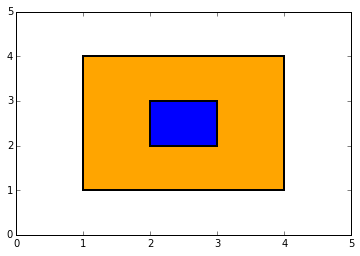

In [3]:
def show_fields(field1, field2):
    def vertices(left, bottom, right, top):
        verts = [(left, bottom),
                 (left, top),
                 (right, top),
                 (right, bottom),
                 (left, bottom)]
        return verts
    
    codes = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY]
    path1 = Path(vertices(*field1), codes)
    path2 = Path(vertices(*field2), codes)         
    fig = plt.figure()
    ax = fig.add_subplot(111)
    patch1 = patches.PathPatch(path1, facecolor='orange', lw=2)
    patch2 = patches.PathPatch(path2, facecolor='blue', lw=2)         
    ax.add_patch(patch1)
    ax.add_patch(patch2)       
    ax.set_xlim(0,5)
    ax.set_ylim(0,5)

show_fields((1.,1.,4.,4.),(2.,2.,3.,3.))

Here, we can see that the area of overlap, is the same as the smaller field, with area 1.

We could now go ahead and write a subroutine to calculate that, and also write some test cases for our answer.

But first, let's just consider that question abstractly, what other cases, *not equivalent to this* might there be?

For example, this case, is still just a full overlap, and is sufficiently equivalent that it's not worth another test:

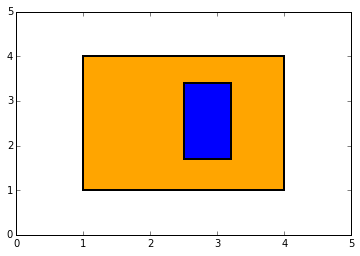

In [4]:
show_fields((1.,1.,4.,4.),(2.5,1.7,3.2,3.4))

But this case is no longer a full overlap, and should be tested separately:

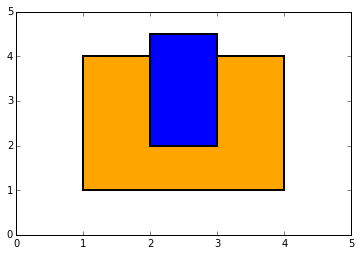

In [5]:
show_fields((1.,1.,4.,4.),(2.,2.,3.,4.5))

On a piece of paper, sketch now the other cases you think should be treated as non-equivalent. The answers are in a separate
notebook.

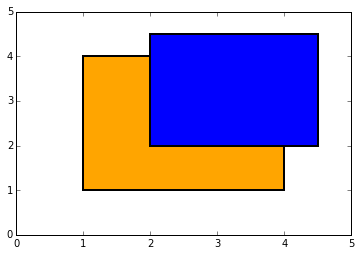

In [6]:
show_fields((1.,1.,4.,4.),(2,2,4.5,4.5)) # Overlap corner

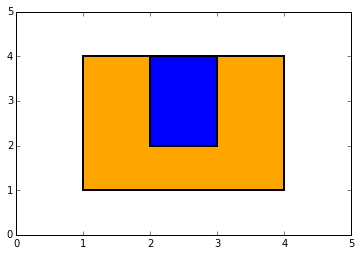

In [7]:
show_fields((1.,1.,4.,4.),(2.,2.,3.,4.)) # Just touching

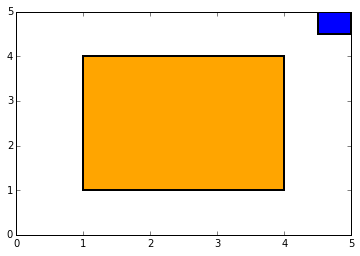

In [8]:
show_fields((1.,1.,4.,4.),(4.5,4.5,5,5)) # No overlap

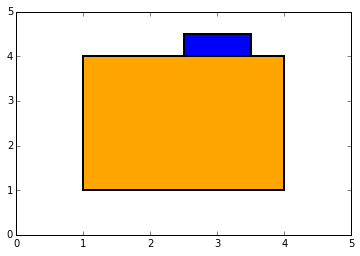

In [9]:
show_fields((1.,1.,4.,4.),(2.5,4,3.5,4.5)) # Just touching from outside

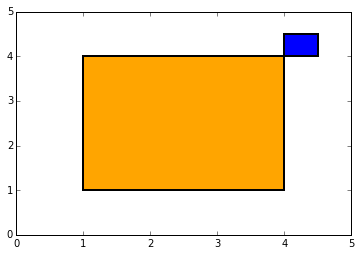

In [10]:
show_fields((1.,1.,4.,4.),(4,4,4.5,4.5)) # Touching corner

### Using our tests

OK, so how might our tests be useful?

Here's some code that **might** correctly calculate the area of overlap:

In [11]:
def overlap(field1, field2):
    left1, bottom1, top1, right1 = field1
    left2, bottom2, top2, right2 = field2
    overlap_left=max(left1, left2)
    overlap_bottom=max(bottom1, bottom2)
    overlap_right=min(right1, right2)
    overlap_top=min(top1, top2)
    overlap_height=(overlap_top-overlap_bottom)
    overlap_width=(overlap_right-overlap_left)
    return overlap_height*overlap_width

So how do we check our code?

The manual approach would be to look at some cases, and, once, run it and check:

In [12]:
overlap((1.,1.,4.,4.),(2.,2.,3.,3.))

1.0

That looks OK.

But we can do better, we can write code which **raises an error** if it gets an unexpected answer:

In [13]:
assert overlap((1.,1.,4.,4.),(2.,2.,3.,3.)) == 1.0

In [14]:
assert overlap((1.,1.,4.,4.),(2.,2.,3.,4.5)) == 2.0 

In [15]:
assert overlap((1.,1.,4.,4.),(2.,2.,4.5,4.5)) == 4.0 

In [16]:
assert overlap((1.,1.,4.,4.),(4.5,4.5,5,5)) == 0.0 

AssertionError: 

In [33]:
print overlap((1.,1.,4.,4.),(4.5,4.5,5,5))

0.25


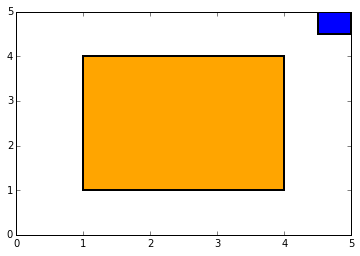

In [34]:
show_fields((1.,1.,4.,4.),(4.5,4.5,5,5))

What? Why is this wrong?

In our calculation, we are actually getting:

In [35]:
overlap_left=4.5
overlap_right=4
overlap_width=-0.5
overlap_height=-0.5

Both width and height are negative, resulting in a positive area.
The above code didn't take into account the non-overlap correctly.

It should be:
    

In [36]:
def overlap(field1, field2):
    left1, bottom1, top1, right1 = field1
    left2, bottom2, top2, right2 = field2
    
    overlap_left=max(left1, left2)
    overlap_bottom=max(bottom1, bottom2)
    overlap_right=min(right1, right2)
    overlap_top=min(top1, top2)
    
    overlap_height=max(0, (overlap_top-overlap_bottom))
    overlap_width=max(0, (overlap_right-overlap_left))
    
    return overlap_height*overlap_width

In [37]:
assert overlap((1,1,4,4),(2,2,3,3)) == 1.0
assert overlap((1,1,4,4),(2,2,3,4.5)) == 2.0 
assert overlap((1,1,4,4),(2,2,4.5,4.5)) == 4.0 
assert overlap((1,1,4,4),(4.5,4.5,5,5)) == 0.0 
assert overlap((1,1,4,4),(2.5,4,3.5,4.5)) == 0.0 
assert overlap((1,1,4,4),(4,4,4.5,4.5)) == 0.0 

Note, we reran our other tests, to check our fix didn't break something else. (We call that "fallout")

### Boundary cases

"Boundary cases" are an important area to test:

* Limit between two equivalence classes: edge and corner sharing fields
* Wherever indices appear, check values at ``0``, ``N``, ``N+1``
* Empty arrays:

``` python
    atoms = [read_input_atom(input_atom) for input_atom in input_file]
    energy = force_field(atoms)
```

* What happens if ``atoms`` is an empty list?
* What happens when a matrix/data-frame reaches one row, or one column?

### Positive *and* negative tests

* **Positive tests**: code should give correct answer with various inputs
* **Negative tests**: code should crash as expected given invalid inputs, rather than lying

<div align="left">
Bad input should be expected and should fail early and explicitly.

<div class="fragment roll-in">
Testing should ensure that explicit failures do indeed happen.

### Raising exceptions

In Python, we can signal an error state by raising an error:

In [38]:
def I_only_accept_positive_numbers(number):
    # Check input
    if number < 0: 
        raise ValueError("Input "+ str(number)+" is negative")

    # Do something

In [39]:
I_only_accept_positive_numbers(5)

In [40]:
I_only_accept_positive_numbers(-5)

ValueError: Input -5 is negative

There are standard "Exception" types, like `ValueError` we can `raise`

We would like to be able to write tests like this:

In [41]:
assert I_only_accept_positive_numbers(-5) == # Gives a value error

SyntaxError: invalid syntax (<ipython-input-41-af84655f8e47>, line 1)

But to do that, we need to learn about more sophisticated testing tools, called "test frameworks".